In [ ]:
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [4]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import os

In [5]:
datapath = 'texts_and_labels_cleaned.tsv'
df = pd.read_csv(datapath, sep='\t')
df.head()

,Unnamed: 0.1,Unnamed: 0,text,label,bias
0,0,0,associated press make clear platform year pres...,elections-2020,center
1,1,1,increasingly bitter dispute woman national soc...,sport,left
2,2,2,speak country first time oval office night pre...,immigration,left
3,3,3,professor teach climate change class subject w...,environment,right
4,4,4,left thing take baby hostage perfect example g...,abortion,right


In [6]:
df.columns = ['1', '2', 'text', 'category', 'bias']

In [7]:
df = df[['text', 'category']]

In [8]:
df['category'].unique()

array(['elections-2020', 'sport', 'immigration', 'environment',
       'abortion', 'student-debt', 'vaccines', 'white-nationalism',
       'coronavirus', 'middle-class', 'gender', 'gun-control',
       'international-politics-and-world-news', 'trump-presidency'],
      dtype=object)

In [9]:
df = df[df['text']!='error']

In [10]:
for ii in range(len(df)):
    if len(df['text'].iloc[ii].split()) > 511:
        df['text'].iloc[ii] = ' '.join(df['text'].iloc[ii].split()[:511])

In [11]:
for ii in range(len(df)):
    if len(df['text'].iloc[ii].split()) > 512:
        print(ii)

<AxesSubplot: xlabel='category'>

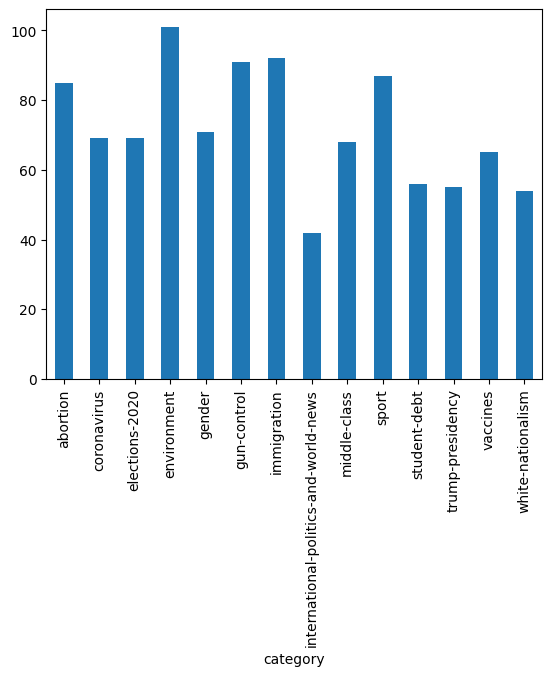

In [12]:
df.groupby(['category']).size().plot.bar()

In [13]:
# labels = {'business':0,
#           '2020':1,
#           'sport':2,
#           'gender':3,
#           'politics':4
#           }

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'elections-2020':0,
          'sport':1,
          'immigration':2,
          'environment':3,
          'abortion':4,
          'student-debt':5,
          'vaccines':6,
          'white-nationalism':7,
          'coronavirus':8, 
          'middle-class':9,
          'gender':10,
          'gun-control':11,
          'international-politics-and-world-news':12,
          'trump-presidency':13}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 14)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [15]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.cuda.is_available()

True

In [16]:
# np.random.seed(112)
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
#                                      [int(.8*len(df)), int(.9*len(df))])


In [17]:
print(len(df_train),len(df_val), len(df_test))
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
            

804 100 101


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
train(model, df_train, df_val, LR, EPOCHS)
evaluate(model, df_test)

100%|██████████| 402/402 [03:24<00:00,  1.97it/s]


Epochs: 1 | Train Loss:  1.327 | Train Accuracy:  0.092 | Val Loss:  1.324 | Val Accuracy:  0.080


100%|██████████| 402/402 [03:45<00:00,  1.78it/s]


Epochs: 2 | Train Loss:  1.320 | Train Accuracy:  0.088 | Val Loss:  1.288 | Val Accuracy:  0.140


100%|██████████| 402/402 [03:34<00:00,  1.87it/s]


Epochs: 3 | Train Loss:  1.295 | Train Accuracy:  0.128 | Val Loss:  1.284 | Val Accuracy:  0.140


100%|██████████| 402/402 [03:37<00:00,  1.85it/s]


Epochs: 4 | Train Loss:  1.247 | Train Accuracy:  0.213 | Val Loss:  1.225 | Val Accuracy:  0.230


100%|██████████| 402/402 [03:43<00:00,  1.80it/s]


Epochs: 5 | Train Loss:  1.190 | Train Accuracy:  0.277 | Val Loss:  1.155 | Val Accuracy:  0.370
Test Accuracy:  0.277


In [19]:
train(model, df_train, df_val, LR, 20)
evaluate(model, df_test)

100%|██████████| 402/402 [03:30<00:00,  1.91it/s]


Epochs: 1 | Train Loss:  1.120 | Train Accuracy:  0.359 | Val Loss:  1.126 | Val Accuracy:  0.350


100%|██████████| 402/402 [03:26<00:00,  1.95it/s]


Epochs: 2 | Train Loss:  1.072 | Train Accuracy:  0.418 | Val Loss:  1.110 | Val Accuracy:  0.380


100%|██████████| 402/402 [03:25<00:00,  1.95it/s]


Epochs: 3 | Train Loss:  1.017 | Train Accuracy:  0.451 | Val Loss:  1.067 | Val Accuracy:  0.400


100%|██████████| 402/402 [03:25<00:00,  1.95it/s]


Epochs: 4 | Train Loss:  0.968 | Train Accuracy:  0.494 | Val Loss:  1.013 | Val Accuracy:  0.480


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 5 | Train Loss:  0.908 | Train Accuracy:  0.544 | Val Loss:  0.968 | Val Accuracy:  0.510


100%|██████████| 402/402 [03:24<00:00,  1.97it/s]


Epochs: 6 | Train Loss:  0.833 | Train Accuracy:  0.637 | Val Loss:  0.921 | Val Accuracy:  0.570


100%|██████████| 402/402 [03:24<00:00,  1.97it/s]


Epochs: 7 | Train Loss:  0.766 | Train Accuracy:  0.682 | Val Loss:  0.859 | Val Accuracy:  0.610


100%|██████████| 402/402 [03:23<00:00,  1.97it/s]


Epochs: 8 | Train Loss:  0.692 | Train Accuracy:  0.710 | Val Loss:  0.808 | Val Accuracy:  0.630


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 9 | Train Loss:  0.645 | Train Accuracy:  0.734 | Val Loss:  0.745 | Val Accuracy:  0.670


100%|██████████| 402/402 [03:22<00:00,  1.98it/s]


Epochs: 10 | Train Loss:  0.585 | Train Accuracy:  0.770 | Val Loss:  0.723 | Val Accuracy:  0.690


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 11 | Train Loss:  0.539 | Train Accuracy:  0.802 | Val Loss:  0.711 | Val Accuracy:  0.670


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 12 | Train Loss:  0.497 | Train Accuracy:  0.810 | Val Loss:  0.643 | Val Accuracy:  0.710


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 13 | Train Loss:  0.456 | Train Accuracy:  0.837 | Val Loss:  0.630 | Val Accuracy:  0.690


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 14 | Train Loss:  0.415 | Train Accuracy:  0.851 | Val Loss:  0.590 | Val Accuracy:  0.740


100%|██████████| 402/402 [36:50<00:00,  5.50s/it]    


Epochs: 15 | Train Loss:  0.384 | Train Accuracy:  0.861 | Val Loss:  0.554 | Val Accuracy:  0.730


100%|██████████| 402/402 [03:23<00:00,  1.98it/s]


Epochs: 16 | Train Loss:  0.355 | Train Accuracy:  0.861 | Val Loss:  0.528 | Val Accuracy:  0.750


100%|██████████| 402/402 [03:22<00:00,  1.99it/s]


Epochs: 17 | Train Loss:  0.321 | Train Accuracy:  0.899 | Val Loss:  0.525 | Val Accuracy:  0.730


100%|██████████| 402/402 [03:22<00:00,  1.98it/s]


Epochs: 18 | Train Loss:  0.294 | Train Accuracy:  0.907 | Val Loss:  0.499 | Val Accuracy:  0.750


100%|██████████| 402/402 [03:25<00:00,  1.96it/s]


Epochs: 19 | Train Loss:  0.265 | Train Accuracy:  0.925 | Val Loss:  0.475 | Val Accuracy:  0.770


100%|██████████| 402/402 [03:24<00:00,  1.97it/s]


Epochs: 20 | Train Loss:  0.240 | Train Accuracy:  0.935 | Val Loss:  0.476 | Val Accuracy:  0.770
Test Accuracy:  0.842
